In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Concatenate

In [10]:
#declaring the u net - encoder function (contracting path)
def encoder_block(inputs,num_filters):
    
    # Convolution with 3 x 3 kernel size followed by ReLU activation
    x = Conv2D(num_filters,
               kernel_size=(3,3),
               padding='valid')(inputs)
    x = Activation('relu')(x)

    # Convolution with 3 X 3 kernel size followed by ReLU activation
    x = Conv2D(num_filters,
               kernel_size=(3,3),
               padding='valid')(x)
    x = Activation('relu')(x)

    # MaxPooling2D with 2 X 2 kernel size 
    x = MaxPooling2D(pool_size=(2,2),strides=2)(x)
    return x

In [11]:
# declaring the u net decoder function (expansive path)
def decoder_block(inputs,skip_features,num_filters):
    
    # Upsampling with 2 x 2 filter
    x = Conv2DTranspose(num_filters,
                        kernel_size=(2,2),
                        strides=2,
                        padding = 'valid')(inputs)
    
    # copy and crop the skip features
    # to match the shape of the upsampled input
    skip_features = tf.image.resize(skip_features,
                        size=(x.shape[1],
                              x.shape[2])
                       )
    x = Concatenate()([x,skip_features])

    # Convolution with 3 X 3 filter followed by ReLU activation
    x = Conv2D(num_filters,
                kernel_size = (3,3),
                padding = 'valid')(x)
    x = Activation('relu')(x)

    # Convolution with 3 X 3 filter followed by ReLU activation
    x = Conv2D(num_filters,
                kernel_size = (3,3),
                padding = 'valid')(x)
    x = Activation('relu')(x)

    return x

In [40]:
# Use this encoding and decoding defining the U net model and printing the model summary
def u_net_model(input_shape=(256,256,3),num_classes=1):

    inputs = Input(input_shape)

    # Contracting path
    e1 = encoder_block(inputs,64) #upsampling by a factor of 64
    e2 = encoder_block(e1,128) # upsampling by a factor of 128
    e3 = encoder_block(e2,256) # upsampling by a factor of 256
    e4 = encoder_block(e3,512) # upsampling by a factor of 512

    # Bottleneck path
    b1 = Conv2D(1024,kernel_size=(3,3),padding='valid')(e4) # bottleneck layer 1
    b1 = Activation('relu')(b1)
    b1 = Conv2D(1024,kernel_size=(3,3),padding='valid')(b1) # bottle neck layer 2
    b1 = Activation('relu')(b1)

    # Expansive path
    d1 = decoder_block(b1,e4,512) # downsampling by a factor 512
    d2 = decoder_block(d1,e3,256) # downsampling by a factor 256
    d3 = decoder_block(d2,e2,128) # downsampling by a factor 128
    d4 = decoder_block(d3,e1,64) # downsampling by a factor 64

    # Output layer
    outputs = Conv2D(num_classes,
                    kernel_size=(1,1),
                    padding = 'valid',
                    activation = 'sigmoid')(d4)

    model = Model(inputs = inputs,
                 outputs = outputs,
                 name = 'U-net')
    return model
if __name__ == '__main__':
    u_model = u_net_model(input_shape=(572,572,3),num_classes=2)
    u_model.summary()

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 572, 572, 3)]        0         []                            
                                                                                                  
 conv2d_114 (Conv2D)         (None, 570, 570, 64)         1792      ['input_7[0][0]']             
                                                                                                  
 activation_108 (Activation  (None, 570, 570, 64)         0         ['conv2d_114[0][0]']          
 )                                                                                                
                                                                                                  
 conv2d_115 (Conv2D)         (None, 568, 568, 64)         36928     ['activation_108[0][0]']  

#### Apply to an image

In [41]:
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

In [42]:
# Image path
image_name = 'cat.png'

In [43]:
# Load the image
img = Image.open(image_name)
# preprocess the image
img = img.resize((572,572))
#plt.imshow(image.img_to_array(img).astype('uint8'))
image_array = image.img_to_array(img)
# expanding the dimensions doing silicing with dimensions 3 (RGB)
image_array = np.expand_dims(image_array[:,:,:3],axis=0)
image_array = image_array/255.

In [44]:
# Load the model
model = u_net_model(input_shape=(572,572,3),
                    num_classes = 2)
#model.summary()

1/1 [==============================] - 0s 23ms/step


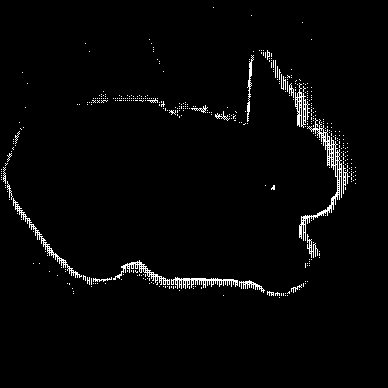

In [62]:
# Make predictions
predictions = model.predict(image_array)
predictions = np.squeeze(predictions,axis=0)
predictions = np.argmax(predictions, axis=-1)
predictions = Image.fromarray(np.uint8(predictions*255)) 
 # Save the image
predictions.save('predicated_cat_image.jpg')
predictions